In [3]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

class CustomDataset(Dataset):
    def __init__(self, rgb_root, depth_root, labels_root, transform=None, limit=7480):
        self.rgb_root = rgb_root
        self.depth_root = depth_root
        self.labels_root = labels_root
        self.transform = transform
        
        self.rgb_files = sorted([f for f in os.listdir(rgb_root) if f.endswith('.png')])[:limit]
        self.depth_files = sorted([f for f in os.listdir(depth_root) if f.endswith('_depth.png')])[:limit]
        
    def __len__(self):
        return len(self.rgb_files)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_root, self.rgb_files[idx])
        depth_path = os.path.join(self.depth_root, self.depth_files[idx])
        label_path = os.path.join(self.labels_root, self.rgb_files[idx].replace('.png', '.txt'))
        
        rgb_image = Image.open(rgb_path).convert("RGB")
        depth_image = Image.open(depth_path).convert("L")
        
        with open(label_path, 'r') as file:
            lines = file.readlines()
            label = self.map_labels(lines)
        
        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = self.transform(depth_image)
        
        label = torch.tensor(label, dtype=torch.long)
        return rgb_image, depth_image, label

    def map_labels(self, lines):
        class_mapping = {
            'Car': 'car',
            'Pedestrian': 'pedestrian',
            'Cyclist': 'cyclist',
        }
        car_count, pedestrian_count, cyclist_count = 0, 0, 0
        
        for line in lines:
            for original_class, dominant_class in class_mapping.items():
                if original_class in line:
                    if dominant_class == 'car':
                        car_count += 1
                    elif dominant_class == 'pedestrian':
                        pedestrian_count += 1
                    elif dominant_class == 'cyclist':
                        cyclist_count += 1
        
        if car_count >= pedestrian_count and car_count >= cyclist_count:
            return 0
        elif pedestrian_count >= car_count and pedestrian_count >= cyclist_count:
            return 1
        else:
            return 2

IMG_ROOT = "path to img files"
SAVE_ROOT = "path to depth img"
LABELS_ROOT = "path to labels"  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

dataset = CustomDataset(IMG_ROOT, SAVE_ROOT, LABELS_ROOT, transform=transform, limit=7480)
train_size = int(0.75 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CSPDarknet(nn.Module):
    def __init__(self, input_channels=3):
        super(CSPDarknet, self).__init__()
        self.layer1 = self._make_layer(input_channels, 32, 1)
        self.layer2 = self._make_layer(32, 64, 2)
        self.layer3 = self._make_layer(64, 128, 2)
        self.layer4 = self._make_layer(128, 256, 2)
        self.layer5 = self._make_layer(256, 512, 2)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = [ConvBlock(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        for _ in range(blocks):
            layers.append(ConvBlock(out_channels, out_channels, kernel_size=1, padding=0))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)
        c5 = self.layer5(c4)
        return c5

class CrossFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(CrossFeatureFusionBlock, self).__init__()
        self.conv1 = ConvBlock(1024, 256, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = ConvBlock(256, 128, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = ConvBlock(128, 64, kernel_size=3, padding=1)
        self.conv4 = ConvBlock(64, 32, kernel_size=3, padding=1)
        self.conv5 = ConvBlock(32, 256, kernel_size=3, padding=1)

    def forward(self, rgb_features, depth_features):
        fused_features = torch.cat((rgb_features, depth_features), dim=1)
        x = self.conv1(fused_features)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.rgb_branch = CSPDarknet(input_channels=3)
        self.depth_branch = CSPDarknet(input_channels=1)

        self.fusion_block = CrossFeatureFusionBlock()
        
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(256 * 28 * 28, 3)

    def forward(self, rgb_image, depth_image):
        rgb_features = self.rgb_branch(rgb_image)
        depth_features = self.depth_branch(depth_image)

        combined_features = self.fusion_block(rgb_features, depth_features)

        fused_features = combined_features.view(combined_features.size(0), -1)
        fused_features = self.dropout(fused_features)
        output = self.classifier(fused_features)
        return output

rgb_image = torch.randn(4, 3, 224, 224)
depth_image = torch.randn(4, 1, 224, 224)
model = SiameseNetwork()
outputs = model(rgb_image, depth_image)
print("Output shape:", outputs.shape)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (rgb_images, depth_images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(rgb_images, depth_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}")
        val_loss = validate_model(model, val_dataloader, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}")
    return model

def validate_model(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (rgb_images, depth_images, labels) in enumerate(val_dataloader):
            outputs = model(rgb_images, depth_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_dataloader)

model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25)

def evaluate_model_per_class(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for rgb_images, depth_images, labels in dataloader:
            outputs = model(rgb_images, depth_images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    metrics = {}
    class_names = ["Car", "Cyclist", "Pedestrian"]
    for class_idx, class_name in enumerate(class_names):
        class_labels = [1 if i == class_idx else 0 for i in all_labels]
        class_preds = [1 if i == class_idx else 0 for i in all_preds]
        class_scores = [score[class_idx] for score in all_scores]
        
        precision, recall, f1, _ = precision_recall_fscore_support(class_labels, class_preds, average='binary')
        ap = average_precision_score(class_labels, class_scores)

        metrics[class_name] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "ap": ap
        }

    return metrics

metrics = evaluate_model_per_class(model, val_dataloader)

def print_metrics_table(metrics):
    print(f"{'Class':<12} {'mAP':<8} {'F1':<8} {'Recall':<8} {'Precision':<8}")
    print("-" * 60)
    
    mAP_total = 0
    for class_name, metric in metrics.items():
        print(f"{class_name:<12} {metric['ap']*100:<8.2f} {metric['f1']*100:<8.2f} {metric['recall']*100:<8.2f} {metric['precision']*100:<8.2f}")
        mAP_total += metric['ap']
    
    mAP_total /= len(metrics)
    print(f"{'Average':<12} {mAP_total*100:<8.2f}")

print_metrics_table(metrics)

Output shape: torch.Size([4, 3])
Epoch [1/25], Loss: 10.859459053122754
Epoch [1/25], Validation Loss: 15.210231328414658
Epoch [2/25], Loss: 60331.34000186821
Epoch [2/25], Validation Loss: 102.37893864259881
Epoch [3/25], Loss: 16.329657055305276
Epoch [3/25], Validation Loss: 4.497361968602922
Epoch [4/25], Loss: 2.3845580004164906
Epoch [4/25], Validation Loss: 2.6640042796478434
Epoch [5/25], Loss: 1.5036005965031818
Epoch [5/25], Validation Loss: 1.6509521324542682
Epoch [6/25], Loss: 1.12428708378469
Epoch [6/25], Validation Loss: 1.5393404986177102
Epoch [7/25], Loss: 1.1117367567645353
Epoch [7/25], Validation Loss: 1.505638335100615
Epoch [8/25], Loss: 0.5502181712575045
Epoch [8/25], Validation Loss: 1.501485791081396
Epoch [9/25], Loss: 0.5300720158927354
Epoch [9/25], Validation Loss: 1.2938207699522628
Epoch [10/25], Loss: 0.49552190898843534
Epoch [10/25], Validation Loss: 1.254479562200732
Epoch [11/25], Loss: 0.4862423817989607
Epoch [11/25], Validation Loss: 1.3569245

c:\Users\Asz22\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Output shape: torch.Size([4, 3])
Epoch [1/25], Loss: 12.240017727258335, Validation Loss: 8.140963877661754
Epoch [2/25], Loss: 2.612735770769756, Validation Loss: 0.44391517915715606
Epoch [3/25], Loss: 0.3825640892821618, Validation Loss: 0.3688274457798166
Epoch [4/25], Loss: 0.36959798862649634, Validation Loss: 0.34620021788750666
Epoch [5/25], Loss: 0.3613929156298665, Validation Loss: 0.3717768324886338
Epoch [6/25], Loss: 0.374837804374031, Validation Loss: 0.36399378513885755
Epoch [7/25], Loss: 0.3580164222724058, Validation Loss: 0.34957761999409076
Epoch [8/25], Loss: 0.34388795981860976, Validation Loss: 0.34628996821278235
Epoch [9/25], Loss: 0.3456029583784667, Validation Loss: 0.34597769190194244
Epoch [10/25], Loss: 0.3447169296189465, Validation Loss: 0.34620256052683973
Epoch [11/25], Loss: 0.34493993722241034, Validation Loss: 0.3487812530691341
Epoch [12/25], Loss: 0.34365592744540086, Validation Loss: 0.3465501394564823
Epoch [13/25], Loss: 0.34284230457110837, Va

c:\Users\Asz22\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asz22\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asz22\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Class        mAP      F1       Recall   Precision
------------------------------------------------------------
Car          90.99    94.26    100.00   89.14   
Cyclist      10.82    0.00     0.00     0.00    
Pedestrian   -0.00    0.00     0.00     0.00    
Average      33.94   


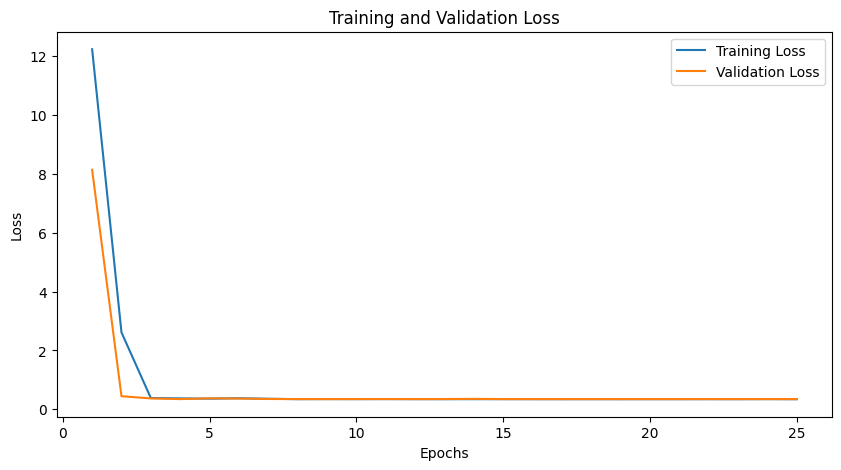

In [1]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, rgb_root, depth_root, labels_root, transform=None, limit=7480):
        self.rgb_root = rgb_root
        self.depth_root = depth_root
        self.labels_root = labels_root
        self.transform = transform
        
        self.rgb_files = sorted([f for f in os.listdir(rgb_root) if f.endswith('.png')])[:limit]
        self.depth_files = sorted([f for f in os.listdir(depth_root) if f.endswith('_depth.png')])[:limit]
        
    def __len__(self):
        return len(self.rgb_files)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_root, self.rgb_files[idx])
        depth_path = os.path.join(self.depth_root, self.depth_files[idx])
        label_path = os.path.join(self.labels_root, self.rgb_files[idx].replace('.png', '.txt'))
        
        rgb_image = Image.open(rgb_path).convert("RGB")
        depth_image = Image.open(depth_path).convert("L")
        
        with open(label_path, 'r') as file:
            lines = file.readlines()
            label = self.map_labels(lines)
        
        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = self.transform(depth_image)
        
        label = torch.tensor(label, dtype=torch.long)
        return rgb_image, depth_image, label

    def map_labels(self, lines):
        class_mapping = {
            'Car': 'car',
            'Pedestrian': 'pedestrian',
            'Cyclist': 'cyclist',
        }
        car_count, pedestrian_count, cyclist_count = 0, 0, 0
        
        for line in lines:
            for original_class, dominant_class in class_mapping.items():
                if original_class in line:
                    if dominant_class == 'car':
                        car_count += 1
                    elif dominant_class == 'pedestrian':
                        pedestrian_count += 1
                    elif dominant_class == 'cyclist':
                        cyclist_count += 1
        
        if car_count >= pedestrian_count and car_count >= cyclist_count:
            return 0
        elif pedestrian_count >= car_count and pedestrian_count >= cyclist_count:
            return 1
        else:
            return 2

IMG_ROOT = "path to img files"
SAVE_ROOT = "path to depth img"
LABELS_ROOT = "path to labels"  
 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

dataset = CustomDataset(IMG_ROOT, SAVE_ROOT, LABELS_ROOT, transform=transform, limit=7480)
train_size = int(0.75 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CSPDarknet(nn.Module):
    def __init__(self, input_channels=3):
        super(CSPDarknet, self).__init__()
        self.layer1 = self._make_layer(input_channels, 32, 1)
        self.layer2 = self._make_layer(32, 64, 2)
        self.layer3 = self._make_layer(64, 128, 2)
        self.layer4 = self._make_layer(128, 256, 2)
        self.layer5 = self._make_layer(256, 512, 2)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = [ConvBlock(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        for _ in range(blocks):
            layers.append(ConvBlock(out_channels, out_channels, kernel_size=1, padding=0))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)
        c5 = self.layer5(c4)
        return c5

class CrossFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(CrossFeatureFusionBlock, self).__init__()
        self.conv1 = ConvBlock(1024, 256, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = ConvBlock(256, 128, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = ConvBlock(128, 64, kernel_size=3, padding=1)
        self.conv4 = ConvBlock(64, 32, kernel_size=3, padding=1)
        self.conv5 = ConvBlock(32, 256, kernel_size=3, padding=1)

    def forward(self, rgb_features, depth_features):
        fused_features = torch.cat((rgb_features, depth_features), dim=1)
        x = self.conv1(fused_features)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.rgb_branch = CSPDarknet(input_channels=3)
        self.depth_branch = CSPDarknet(input_channels=1)

        self.fusion_block = CrossFeatureFusionBlock()
        
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(256 * 28 * 28, 3)

    def forward(self, rgb_image, depth_image):
        rgb_features = self.rgb_branch(rgb_image)
        depth_features = self.depth_branch(depth_image)

        combined_features = self.fusion_block(rgb_features, depth_features)

        fused_features = combined_features.view(combined_features.size(0), -1)
        fused_features = self.dropout(fused_features)
        output = self.classifier(fused_features)
        return output

rgb_image = torch.randn(4, 3, 224, 224)
depth_image = torch.randn(4, 1, 224, 224)
model = SiameseNetwork()
outputs = model(rgb_image, depth_image)
print("Output shape:", outputs.shape)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (rgb_images, depth_images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(rgb_images, depth_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()

        epoch_train_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)
        
        val_loss = validate_model(model, val_dataloader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_train_loss}, Validation Loss: {val_loss}")

    return model, train_losses, val_losses

def validate_model(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (rgb_images, depth_images, labels) in enumerate(val_dataloader):
            outputs = model(rgb_images, depth_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_dataloader)

model, train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25)

def evaluate_model_per_class(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for rgb_images, depth_images, labels in dataloader:
            outputs = model(rgb_images, depth_images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    metrics = {}
    class_names = ["Car", "Cyclist", "Pedestrian"]
    for class_idx, class_name in enumerate(class_names):
        class_labels = [1 if i == class_idx else 0 for i in all_labels]
        class_preds = [1 if i == class_idx else 0 for i in all_preds]
        class_scores = [score[class_idx] for score in all_scores]
        
        precision, recall, f1, _ = precision_recall_fscore_support(class_labels, class_preds, average='binary')
        ap = average_precision_score(class_labels, class_scores)

        metrics[class_name] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "ap": ap
        }

    return metrics

metrics = evaluate_model_per_class(model, val_dataloader)

def print_metrics_table(metrics):
    print(f"{'Class':<12} {'mAP':<8} {'F1':<8} {'Recall':<8} {'Precision':<8}")
    print("-" * 60)
    
    mAP_total = 0
    for class_name, metric in metrics.items():
        print(f"{class_name:<12} {metric['ap']*100:<8.2f} {metric['f1']*100:<8.2f} {metric['recall']*100:<8.2f} {metric['precision']*100:<8.2f}")
        mAP_total += metric['ap']
    
    mAP_total /= len(metrics)
    print(f"{'Average':<12} {mAP_total*100:<8.2f}")

print_metrics_table(metrics)

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
